In [ ]:
# Empêcher Colab de se déconnecter (à exécuter dans une cellule séparée)
import IPython
from google.colab import output

display(IPython.display.Javascript('''
function ClickConnect(){
  console.log("Working");
  document.querySelector("colab-toolbar-button#connect").click()
}
setInterval(ClickConnect, 60000)
'''))

<IPython.core.display.Javascript object>

# **Importation des bibliothèques**

In [ ]:
import os
import cv2
import pandas as pd
import numpy as np
import matplotlib.pyplot as  plt
import dlib
from imutils import face_utils
import tensorflow as tf
from tensorflow import keras
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
import seaborn as sns
tf.random.set_seed(3)
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

extensions_images_valides = ('.jpg', '.jpeg', '.png', '.bmp', '.tiff', '.gif', '.webp')

print("TensorFlow version:", tf.__version__)
print("OpenCV version :", cv2.__version__)

TensorFlow version: 2.18.0
OpenCV version : 4.11.0


In [ ]:
# import os

# folder = '/content/drive/MyDrive/kaggle/drowsiness_ddd_data/Driver Drowsiness Dataset (DDD)'

# for root, dirs, files in os.walk(folder):
#     print(f"\n📁 Dossier : {root}")
#     for f in files:
#         print(f"   - {f}")

In [ ]:
# import os
# import random
# import shutil
# import time
# from tqdm import tqdm

# def copy_drowsiness_dataset_extract(chemin_base_original, destination_extraction, sample_ratio=0.1, seed=42):
#     """
#     Copie un pourcentage d’un dataset structuré en sous-dossiers vers un nouveau dossier plus rapidement.

#     Args:
#         chemin_base_original (str): Chemin du dossier source.
#         destination_extraction (str): Chemin du dossier de destination.
#         sample_ratio (float): Pourcentage d’échantillonnage.
#         seed (int): Graine aléatoire pour la reproductibilité.

#     Returns:
#         int: Nombre de fichiers copiés.
#     """
#     random.seed(seed)
#     start_time = time.time()
#     files_to_copy = []

#     # Phase 1 : Recenser les fichiers à copier rapidement
#     for root, dirs, files in os.walk(chemin_base_original):
#         if files:
#             sample_size = max(1, int(len(files) * sample_ratio))
#             sampled_files = random.sample(files, sample_size)
#             files_to_copy.extend([(root, f) for f in sampled_files])

#     print(f"📦 Démarrage de la copie de {len(files_to_copy)} fichiers ({int(sample_ratio * 100)}%)...\n")

#     created_dirs = set()

#     # Phase 2 : Copier avec cache de répertoires
#     for root, f in tqdm(files_to_copy, desc="📤 Copie en cours", unit="fichier"):
#         relative_path = os.path.relpath(root, chemin_base_original)
#         dest_subfolder = os.path.join(destination_extraction, relative_path)

#         if dest_subfolder not in created_dirs:
#             os.makedirs(dest_subfolder, exist_ok=True)
#             created_dirs.add(dest_subfolder)

#         src = os.path.join(root, f)
#         dst = os.path.join(dest_subfolder, f)

#         shutil.copyfile(src, dst)  # plus rapide que copy2

#     elapsed = time.time() - start_time
#     print(f"\n✅ Copie terminée en {elapsed:.2f} secondes.")
#     return len(files_to_copy)

# # Exemple d'utilisation
# chemin_base_original = '/content/drive/MyDrive/kaggle/drowsiness_ddd_data/Driver Drowsiness Dataset (DDD)'
# destination_extraction = '/content/drive/MyDrive/kaggle/drowsiness_ddd_data/drowsiness_dataset_extract'

# nb_files = copy_drowsiness_dataset_extract(chemin_base_original, destination_extraction, sample_ratio=0.1)
# print(f"📁 Total copié : {nb_files} fichiers.")


Chemin vers les images de somnolence : /content/drive/MyDrive/kaggle/drowsiness_ddd_data/Driver Drowsiness Dataset (DDD)/Drowsy
Chemin vers les images sans somnolence : /content/drive/MyDrive/kaggle/drowsiness_ddd_data/Driver Drowsiness Dataset (DDD)/Non Drowsy
Nombre d'images de somnolence : 22348
Nombre d'images sans somnolence : 19445
Nombre total d'images : 41793


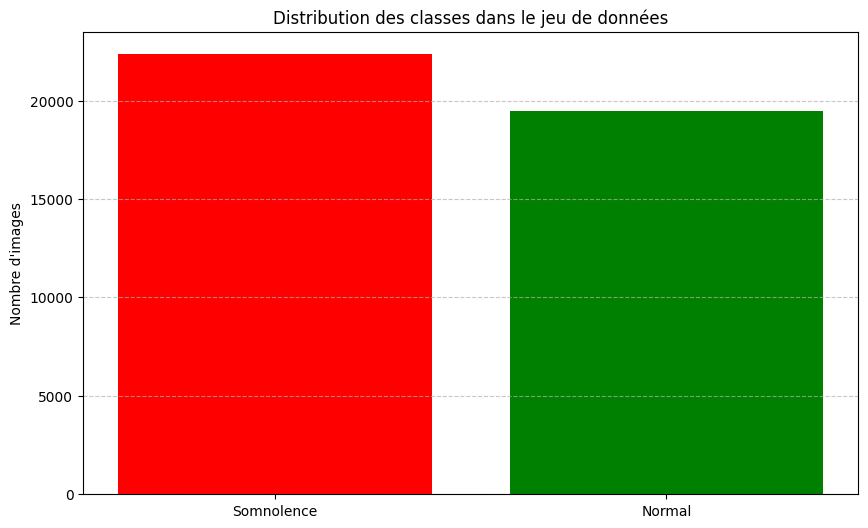

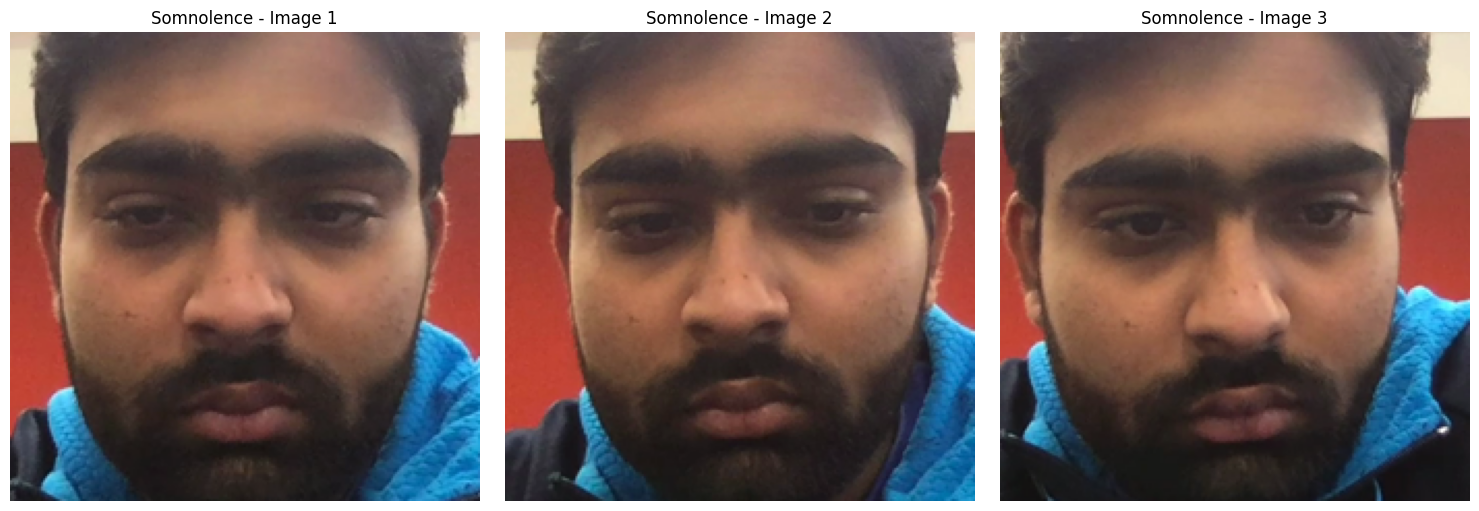

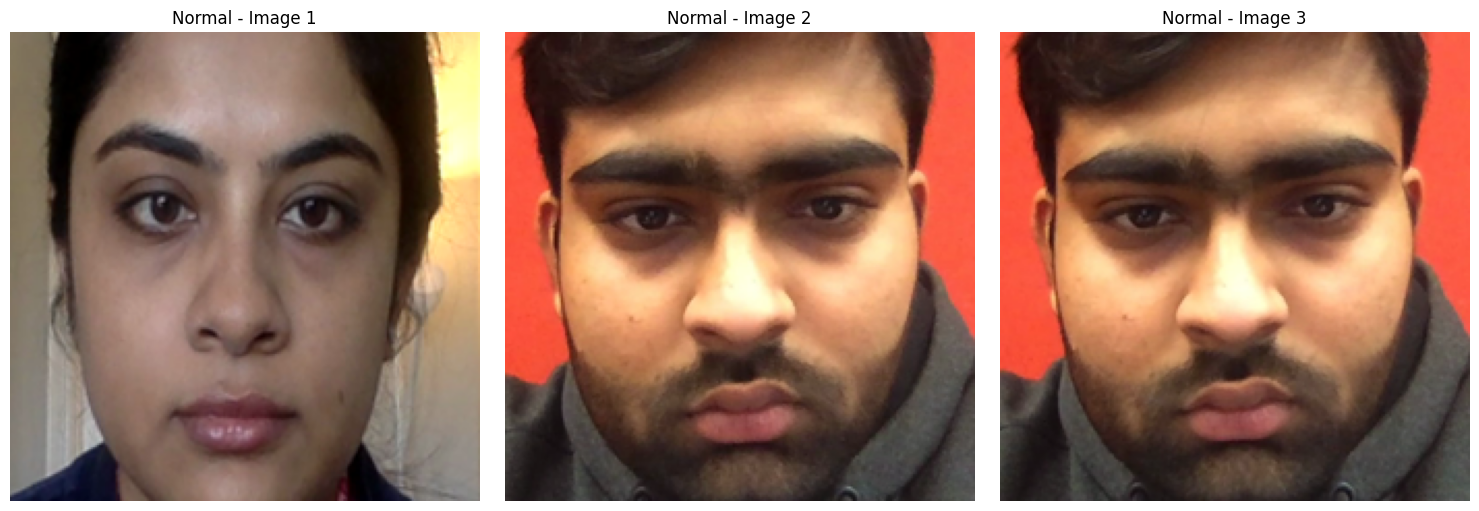

In [ ]:
# Définir les chemins des dossiers contenant les images
chemin_base = '/content/drive/MyDrive/kaggle/drowsiness_ddd_data/Driver Drowsiness Dataset (DDD)'
dossier_drowsy = os.path.join(chemin_base, "Drowsy")
dossier_non_drowsy = os.path.join(chemin_base, "Non Drowsy")

# Vérification des chemins et comptage des fichiers
print(f"Chemin vers les images de somnolence : {dossier_drowsy}")
print(f"Chemin vers les images sans somnolence : {dossier_non_drowsy}")

nb_images_drowsy = len([f for f in os.listdir(dossier_drowsy) if f.lower().endswith(extensions_images_valides)])
nb_images_non_drowsy = len([f for f in os.listdir(dossier_non_drowsy) if f.lower().endswith(extensions_images_valides)])


print(f"Nombre d'images de somnolence : {nb_images_drowsy}")
print(f"Nombre d'images sans somnolence : {nb_images_non_drowsy}")
print(f"Nombre total d'images : {nb_images_drowsy + nb_images_non_drowsy}")

# Visualisation de la distribution des données
plt.figure(figsize=(10, 6))
plt.bar(['Somnolence', 'Normal'], [nb_images_drowsy, nb_images_non_drowsy], color=['red', 'green'])
plt.title('Distribution des classes dans le jeu de données')
plt.ylabel('Nombre d\'images')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# Fonction pour afficher quelques exemples d'images
def afficher_exemples(dossier, titre, nb_images=3):
    plt.figure(figsize=(15, 5))
    fichiers = [f for f in os.listdir(dossier) if f.lower().endswith(extensions_images_valides)][:nb_images]

    for i, fichier in enumerate(fichiers):
        img = cv2.imread(os.path.join(dossier, fichier))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Conversion BGR à RGB

        plt.subplot(1, nb_images, i+1)
        plt.imshow(img)
        plt.title(f"{titre} - Image {i+1}")
        plt.axis('off')

    plt.tight_layout()
    plt.show()

# Afficher des exemples d'images
afficher_exemples(dossier_drowsy, "Somnolence")
afficher_exemples(dossier_non_drowsy, "Normal")

**Après extraction**

Chemin vers les images de somnolence : /content/drive/MyDrive/kaggle/drowsiness_ddd_data/drowsiness_dataset_extract/Drowsy
Chemin vers les images sans somnolence : /content/drive/MyDrive/kaggle/drowsiness_ddd_data/drowsiness_dataset_extract/Non Drowsy
Nombre d'images de somnolence : 2234
Nombre d'images sans somnolence : 1944
Nombre total d'images : 4178


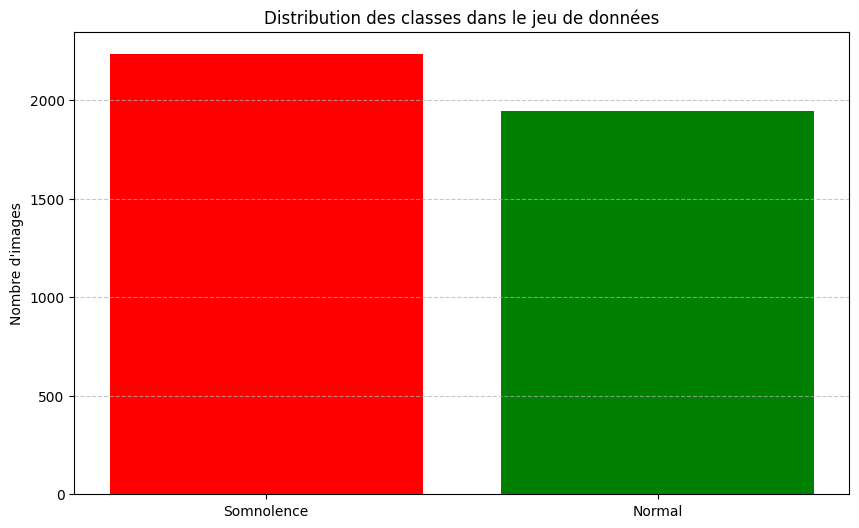

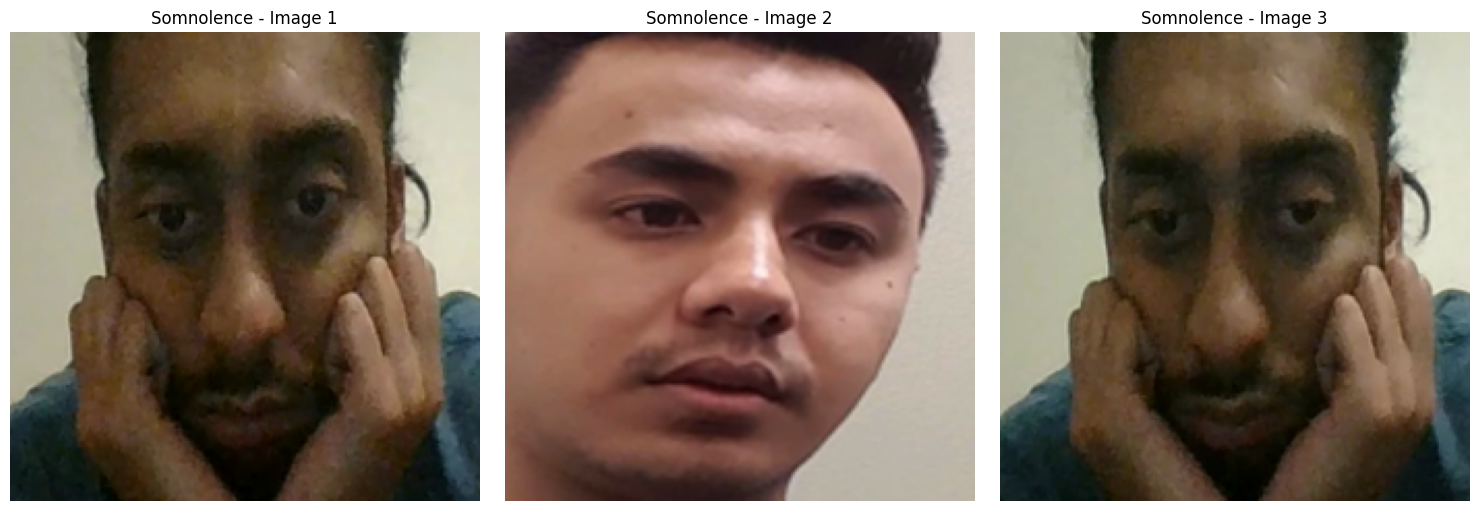

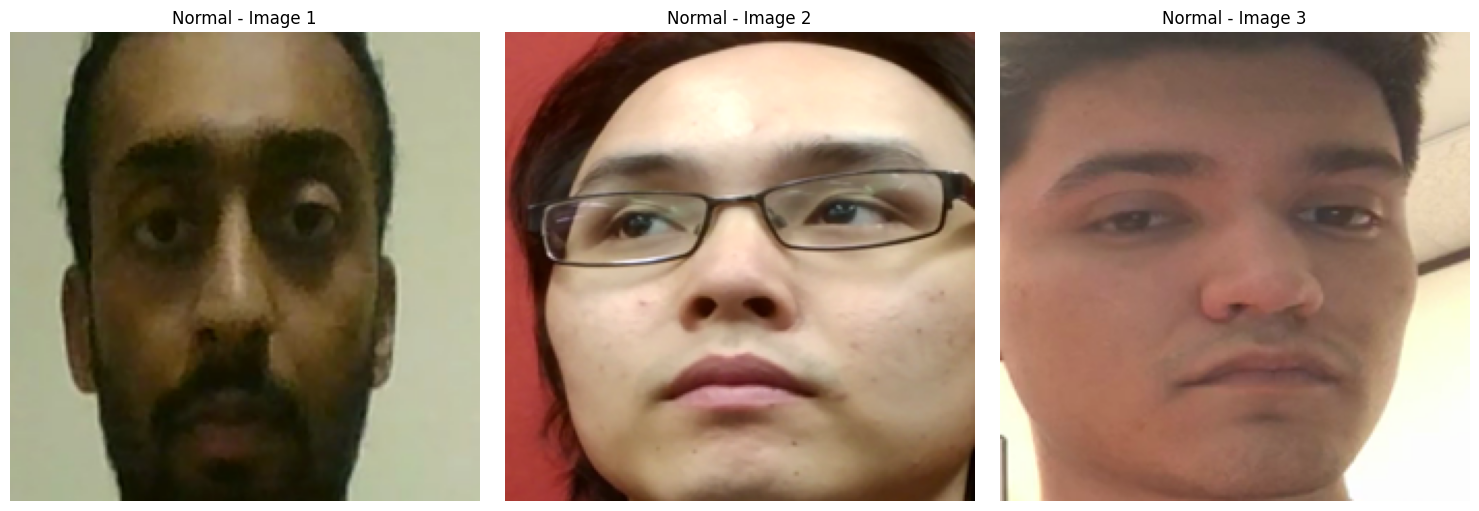

Found 3344 images belonging to 2 classes.
Found 834 images belonging to 2 classes.
Classes mappées : {'Drowsy': 0, 'Non Drowsy': 1}


In [ ]:
# Définir les chemins des dossiers contenant les images
chemin_base = '/content/drive/MyDrive/kaggle/drowsiness_ddd_data/drowsiness_dataset_extract'
dossier_drowsy = os.path.join(chemin_base, "Drowsy")
dossier_non_drowsy = os.path.join(chemin_base, "Non Drowsy")

# Vérification des chemins et comptage des fichiers
print(f"Chemin vers les images de somnolence : {dossier_drowsy}")
print(f"Chemin vers les images sans somnolence : {dossier_non_drowsy}")

nb_images_drowsy = len([f for f in os.listdir(dossier_drowsy) if f.lower().endswith(extensions_images_valides)])
nb_images_non_drowsy = len([f for f in os.listdir(dossier_non_drowsy) if f.lower().endswith(extensions_images_valides)])


print(f"Nombre d'images de somnolence : {nb_images_drowsy}")
print(f"Nombre d'images sans somnolence : {nb_images_non_drowsy}")
print(f"Nombre total d'images : {nb_images_drowsy + nb_images_non_drowsy}")

# Visualisation de la distribution des données
plt.figure(figsize=(10, 6))
plt.bar(['Somnolence', 'Normal'], [nb_images_drowsy, nb_images_non_drowsy], color=['red', 'green'])
plt.title('Distribution des classes dans le jeu de données')
plt.ylabel('Nombre d\'images')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# Fonction pour afficher quelques exemples d'images
def afficher_exemples(dossier, titre, nb_images=3):
    plt.figure(figsize=(15, 5))
    fichiers = [f for f in os.listdir(dossier) if f.lower().endswith(extensions_images_valides)][:nb_images]

    for i, fichier in enumerate(fichiers):
        img = cv2.imread(os.path.join(dossier, fichier))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Conversion BGR à RGB

        plt.subplot(1, nb_images, i+1)
        plt.imshow(img)
        plt.title(f"{titre} - Image {i+1}")
        plt.axis('off')

    plt.tight_layout()
    plt.show()

# Afficher des exemples d'images
afficher_exemples(dossier_drowsy, "Somnolence")
afficher_exemples(dossier_non_drowsy, "Normal")

# Configuration des générateurs de données pour l'augmentation et le prétraitement
taille_image = (160, 160)
batch_size = 128

# Générateur pour l'entraînement avec augmentation de données
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    validation_split=0.2  # 20% pour la validation
)

# Générateur pour le test sans augmentation
test_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

# Chargement des données d'entraînement
train_generator = train_datagen.flow_from_directory(
    chemin_base,
    target_size=taille_image,
    batch_size=batch_size,
    class_mode='binary',
    subset='training'
)

# Chargement des données de validation
validation_generator = test_datagen.flow_from_directory(
    chemin_base,
    target_size=taille_image,
    batch_size=batch_size,
    class_mode='binary',
    subset='validation'
)

print("Classes mappées :", train_generator.class_indices)

**Création des dossiers train, test, val**

In [ ]:
# !pip install split-folders
# import splitfolders

# data_extract_dir = '/content/drive/MyDrive/kaggle/drowsiness_ddd_data/drowsiness_dataset_extract'
# output_extract_dir = '/content/drive/MyDrive/kaggle/drowsiness_ddd_data/drowsiness_dataset_split'

# splitfolders.ratio(data_extract_dir, output=output_extract_dir, seed=1337, ratio=(0.7, 0.2, 0.1))

**Exploration des dossiers (train, test, val)**

In [ ]:
train_dir = "/content/drive/MyDrive/kaggle/drowsiness_ddd_data/drowsiness_dataset_split/train"
test_dir = "/content/drive/MyDrive/kaggle/drowsiness_ddd_data/drowsiness_dataset_split/test"
val_dir = "/content/drive/MyDrive/kaggle/drowsiness_ddd_data/drowsiness_dataset_split/val"

In [ ]:
#Création instance de données pour for train, test et la validation
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)

**Mise à jour des DataGenerators**

In [ ]:
# Nombres d'images par dossiers
image_size = (160, 160)
batch_size = 64
epochs = 20

# Définition des générateurs de données
print("image pour train")
train_batches = train_datagen.flow_from_directory(
    train_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='binary',
    shuffle=True
)

print("image total pour test")

test_batches = test_datagen.flow_from_directory(
    test_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='binary' ,
    shuffle=False
)

print("image total pour validation")

val_batches = val_datagen.flow_from_directory(
    val_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False
)

image pour train
Found 2923 images belonging to 2 classes.
image total pour test
Found 421 images belonging to 2 classes.
image total pour validation
Found 834 images belonging to 2 classes.


**Configuration des générateurs de données**

In [ ]:
# Vérification du nombres d'occurrences pour chaque classe

import pandas as pd
from collections import Counter

# Obtenir les indices de classes
train_class_indices = train_batches.class_indices
test_class_indices = test_batches.class_indices
val_class_indices = val_batches.class_indices

# Obtenir les étiquettes de classes
train_class_labels = train_batches.classes
test_class_labels = test_batches.classes
val_class_labels = val_batches.classes

# Compter les occurrences
train_class_counts = Counter(train_class_labels)
test_class_counts = Counter(test_class_labels)
val_class_counts = Counter(val_class_labels)

# Inverser les indices pour afficher les noms
inv_train_class_indices = {v: k for k, v in train_class_indices.items()}

# Créer les DataFrames
train_df = pd.DataFrame({
    'Classe': [inv_train_class_indices[i] for i in train_class_counts.keys()],
    'Index': list(train_class_counts.keys()),
    'Occurrences': list(train_class_counts.values())
})

test_df = pd.DataFrame({
    'Classe': [inv_train_class_indices[i] for i in test_class_counts.keys()],
    'Index': list(test_class_counts.keys()),
    'Occurrences': list(test_class_counts.values())
})

val_df = pd.DataFrame({
    'Classe': [inv_train_class_indices[i] for i in val_class_counts.keys()],
    'Index': list(val_class_counts.keys()),
    'Occurrences': list(val_class_counts.values())
})

# Affichage
print("Train set:\n", train_df.to_string(index=False))
print("\nTest set:\n", test_df.to_string(index=False))
print("\nValidation set:\n", val_df.to_string(index=False))

Train set:
     Classe  Index  Occurrences
    Drowsy      0         1563
Non Drowsy      1         1360

Test set:
     Classe  Index  Occurrences
    Drowsy      0          225
Non Drowsy      1          196

Validation set:
     Classe  Index  Occurrences
    Drowsy      0          446
Non Drowsy      1          388


**Vérification de la Normalisation**

Pixels de la première image après normalisation: 

[[[0.78823537 0.7372549  0.64705884]
  [0.78823537 0.7372549  0.64705884]
  [0.7843138  0.73333335 0.6431373 ]
  ...
  [0.19607845 0.12941177 0.07843138]
  [0.20000002 0.12941177 0.07843138]
  [0.20000002 0.13725491 0.08627451]]

 [[0.79215693 0.7411765  0.6509804 ]
  [0.78823537 0.7372549  0.64705884]
  [0.78823537 0.7372549  0.64705884]
  ...
  [0.18823531 0.1137255  0.07058824]
  [0.18823531 0.12156864 0.07843138]
  [0.19215688 0.1254902  0.08627451]]

 [[0.79215693 0.7411765  0.6509804 ]
  [0.78823537 0.7372549  0.64705884]
  [0.78823537 0.7372549  0.64705884]
  ...
  [0.18431373 0.1137255  0.07450981]
  [0.18823531 0.12156864 0.07843138]
  [0.19215688 0.1254902  0.08235294]]

 ...

 [[0.8470589  0.7803922  0.7372549 ]
  [0.854902   0.78823537 0.7411765 ]
  [0.854902   0.78823537 0.7411765 ]
  ...
  [0.47058827 0.34901962 0.34901962]
  [0.45882356 0.34117648 0.33333334]
  [0.47058827 0.3529412  0.3529412 ]]

 [[0.8470589  0.7764706

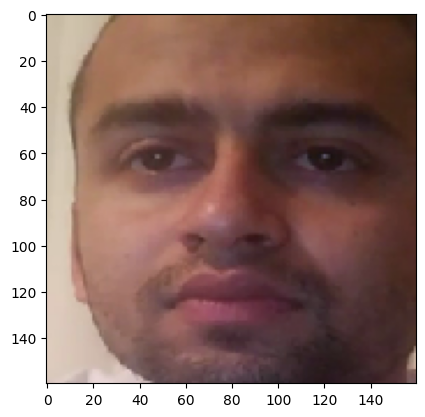

Forme exacte de l'image 1 en couleur (hauteur, largeur, canaux): (160, 160, 3)
Nombre de paramètres : 3


In [ ]:
images, labels = next(train_batches)
print(f"Pixels de la première image après normalisation: \n\n{images[0]}")
plt.imshow(images[0])
plt.show()

#Affichage des dimensions et du nombre de canaux de la première image
print(f"Forme exacte de l'image 1 en couleur (hauteur, largeur, canaux): {images[0].shape}")
if images[0].ndim == 3:
    print(f"Nombre de paramètres : {images[0].shape[-1]}")
elif images[0].ndim == 2:
    print("Grayscale image (1 channel)")

**Afficher les 50 premières images d'entraînement**

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Création de la grille 10x5 (50 images)
fig, axes = plt.subplots(10, 5, figsize=(20, 30))
class_indices = train_batches.class_indices

# Total de 50 images à afficher
image_count = 0
for _ in range(10):  # 10 lots à prélever
    images, labels = next(train_batches)
    for j in range(5):  # 5 images par lot
        if image_count >= 50:
            break
        row = image_count // 5
        col = image_count % 5
        ax = axes[row, col]

        # Affichage de l’image
        ax.imshow(images[j])
        ax.axis('off')

        # Conversion correcte du label one-hot en index
        label = np.argmax(labels[j])  # ✅ Corrigé ici
        label_name = list(class_indices.keys())[label]
        ax.set_title(f'{label_name} ({label})')

        image_count += 1

plt.tight_layout()
plt.show()

**Identification des signes de somnolence et non-somnolence**

In [ ]:
import pandas as pd

# === 1. Signes de somnolence ===
signes_somnolence = {
    "yeux_fermes": {
        "description": "Les yeux sont complètement ou partiellement fermés pendant plus de 2 secondes",
        "gravité": 3,
        "détectable": "Rapport entre la hauteur et la largeur des yeux inférieur à un seuil"
    },
    "bâillements": {
        "description": "Ouverture prolongée de la bouche indiquant un bâillement",
        "gravité": 2,
        "détectable": "Rapport hauteur/largeur de la bouche supérieur à un seuil"
    },
    "clignements_lents": {
        "description": "Clignements des yeux anormalement lents ou irréguliers",
        "gravité": 2,
        "détectable": "Temps entre l'ouverture et la fermeture des yeux"
    },
    "hochements_tete": {
        "description": "Mouvement de la tête vers le bas indiquant l'assoupissement",
        "gravité": 3,
        "détectable": "Angle d'inclinaison de la tête par rapport à la verticale"
    },
    "regard_fixe": {
        "description": "Regard figé sans mouvement pendant une période prolongée",
        "gravité": 2,
        "détectable": "Absence de mouvement des yeux pendant plusieurs secondes"
    },
    "micro_sommeil": {
        "description": "Brefs épisodes de sommeil de quelques secondes",
        "gravité": 3,
        "détectable": "Combinaison de fermeture des yeux et d'absence de mouvement"
    },
    "expression_fatiguée": {
        "description": "Relâchement des muscles faciaux, notamment autour des yeux",
        "gravité": 1,
        "détectable": "Modification des distances entre points faciaux clés"
    }
}

# === 2. Signes de conduite normale ===
signes_normal = {
    "yeux_ouverts": {
        "description": "Les yeux sont complètement ouverts, attentifs à la route",
        "détectable": "Rapport entre la hauteur et la largeur des yeux supérieur à un seuil"
    },
    "balayage_visuel": {
        "description": "Le conducteur scanne régulièrement les rétroviseurs et la route",
        "détectable": "Mouvements réguliers des yeux et de la tête"
    },
    "posture_droite": {
        "description": "La tête et le corps sont maintenus dans une position droite",
        "détectable": "Angle de la tête proche de la verticale"
    },
    "expressions_alertes": {
        "description": "Visage expressif, réactif aux stimuli de l'environnement",
        "détectable": "Changements réguliers dans les expressions faciales"
    },
    "clignements_normaux": {
        "description": "Fréquence de clignement normale (15-20 fois par minute)",
        "détectable": "Fréquence et rapidité des clignements"
    },
    "bouche_fermée": {
        "description": "Bouche normalement fermée, pas de bâillements",
        "détectable": "Rapport hauteur/largeur de la bouche inférieur à un seuil"
    }
}

# === 3. Liste des signes prioritaires ===
signes_prioritaires = ["yeux_fermes", "micro_sommeil", "hochements_tete", "bâillements",
                       "clignements_lents", "regard_fixe", "expression_fatiguée"]

# === 4. Création des DataFrames ===

# Somnolence
data_somnolence = [
    {
        "Signe": signe.replace('_', ' ').title(),
        "Gravité": details["gravité"],
        "Description": details["description"],
        "Méthode de détection": details["détectable"]
    }
    for signe, details in signes_somnolence.items()
]
df_somnolence = pd.DataFrame(data_somnolence)

# Normale
data_normal = [
    {
        "Signe": signe.replace('_', ' ').title(),
        "Description": details["description"],
        "Méthode de détection": details["détectable"]
    }
    for signe, details in signes_normal.items()
]
df_normal = pd.DataFrame(data_normal)

# Prioritaires
data_prioritaires = [
    {
        "Priorité": i + 1,
        "Signe": signe.replace('_', ' ').title(),
        "Gravité": signes_somnolence[signe]["gravité"],
        "Description": signes_somnolence[signe]["description"]
    }
    for i, signe in enumerate(signes_prioritaires)
]
df_prioritaires = pd.DataFrame(data_prioritaires)

# === 5. Export CSV ===

df_somnolence.to_csv("signes_somnolence.csv", index=False)
df_normal.to_csv("signes_normale.csv", index=False)
df_prioritaires.to_csv("signes_prioritaires.csv", index=False)

print("✅ Export terminé avec succès !")
print("📄 Fichiers générés :")
print("- signes_somnolence.csv")
print("- signes_normale.csv")
print("- signes_prioritaires.csv")


✅ Export terminé avec succès !
📄 Fichiers générés :
- signes_somnolence.csv
- signes_normale.csv
- signes_prioritaires.csv


**détecteurs et prédicteurs pour les points du visage**

In [ ]:
import cv2
import dlib
import os
import numpy as np
from imutils import face_utils
import matplotlib.pyplot as plt
import random


**Fonctions utilitaires pour les detecteurs**

In [ ]:
def charger_detecteurs():
    detecteur_visage = dlib.get_frontal_face_detector()
    chemin_predicteur = "/content/drive/MyDrive/kaggle/shape_predictor_68_face_landmarks.dat"
    try:
        predicteur_points = dlib.shape_predictor(chemin_predicteur)
        print("Détecteurs chargés avec succès")
        return detecteur_visage, predicteur_points
    except RuntimeError:
        print(f"ERREUR: Impossible de charger le fichier {chemin_predicteur}")
        return None, None

def definir_indices_points():
    return {
        "machoire": list(range(0, 17)),
        "sourcil_droit": list(range(17, 22)),
        "sourcil_gauche": list(range(22, 27)),
        "nez_pont": list(range(27, 31)),
        "nez_bas": list(range(31, 36)),
        "oeil_droit": list(range(36, 42)),
        "oeil_gauche": list(range(42, 48)),
        "levre_exterieure": list(range(48, 60)),
        "levre_interieure": list(range(60, 68))
    }

signes_somnolence = ["yeux_fermes", "bâillements", "hochements_tete"]


**Fonctions de détection et d'analyse (avec ta règle stricte intégrée)**

In [ ]:
def detecter_points_visage(image, detecteur_visage, predicteur_points):
    gris = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    gris = clahe.apply(gris)
    visages = detecteur_visage(gris, 1)
    resultats = []
    for visage in visages:
        x1, y1, x2, y2 = visage.left(), visage.top(), visage.right(), visage.bottom()
        points = predicteur_points(gris, visage)
        points = face_utils.shape_to_np(points)
        resultats.append({
            "rectangle": (x1, y1, x2, y2),
            "points": points
        })
    return resultats

def extraire_caracteristiques(resultats_detection, indices_visage):
    if not resultats_detection:
        return None

    visage = resultats_detection[0]
    points = visage["points"]

    oeil_droit = points[indices_visage["oeil_droit"]]
    oeil_gauche = points[indices_visage["oeil_gauche"]]
    levre_ext = points[48:60]  # Correct 12 points

    def calculer_ear(oeil):
        A = np.linalg.norm(oeil[1] - oeil[5])
        B = np.linalg.norm(oeil[2] - oeil[4])
        C = np.linalg.norm(oeil[0] - oeil[3])
        return (A + B) / (2.0 * C)

    ear_droit = calculer_ear(oeil_droit)
    ear_gauche = calculer_ear(oeil_gauche)
    ear_moyen = (ear_droit + ear_gauche) / 2.0

    bouche_haut = levre_ext[3]
    bouche_bas = levre_ext[9]
    bouche_gauche = levre_ext[0]
    bouche_droite = levre_ext[6]

    hauteur_bouche = np.linalg.norm(bouche_haut - bouche_bas)
    largeur_bouche = np.linalg.norm(bouche_gauche - bouche_droite)
    mar = hauteur_bouche / largeur_bouche

    oeil_droit_centre = np.mean(oeil_droit, axis=0)
    oeil_gauche_centre = np.mean(oeil_gauche, axis=0)
    angle_yeux = np.degrees(np.arctan2(
        oeil_gauche_centre[1] - oeil_droit_centre[1],
        oeil_gauche_centre[0] - oeil_droit_centre[0]
    ))

    return {
        "ear_droit": ear_droit,
        "ear_gauche": ear_gauche,
        "ear_moyen": ear_moyen,
        "mar": mar,
        "angle_tete": angle_yeux
    }

def analyser_image(image, detecteur_visage, predicteur_points, indices_visage,
                   seuil_ear=0.25, seuil_mar=0.6, seuil_angle=10):
    resultats_detection = detecter_points_visage(image, detecteur_visage, predicteur_points)
    if not resultats_detection:
        return {"signes_detectes": [], "message": "Aucun visage détecté", "resultats_detection": None}
    caract = extraire_caracteristiques(resultats_detection, indices_visage)
    if not caract:
        return {"signes_detectes": [], "message": "Impossible d'extraire les caractéristiques", "resultats_detection": resultats_detection}
    signes_detectes = []
    if caract["ear_moyen"] < seuil_ear:
        signes_detectes.append("yeux_fermes")
    else:
        signes_detectes.append("yeux_ouverts")
    if caract["mar"] > seuil_mar:
        signes_detectes.append("bâillements")
    else:
        signes_detectes.append("bouche_fermée")
    if abs(caract["angle_tete"]) > seuil_angle:
        signes_detectes.append("hochements_tete")
    else:
        signes_detectes.append("posture_droite")
    nb_signes_somnolence = len([s for s in signes_detectes if s in signes_somnolence])
    if "yeux_fermes" in signes_detectes:
        message = "ALERTE: Yeux fermés détectés. Fatigue grave conduite pas du tout requise."
        statut = "FATIGUE"
    elif nb_signes_somnolence >= 2:
        message = "ALERTE: Plusieurs signes de fatigue détectés pas de conduite requise."
        statut = "FATIGUE"
    else:
        message = "Normal: Conduite normale requise."
        statut = "NORMAL"
    return {
        "signes_detectes": signes_detectes,
        "caracteristiques": caract,
        "message": message,
        "statut": statut,
        "resultats_detection": resultats_detection
    }

def visualiser_analyse(image, resultats_detection, analyse):
    image_affichage = image.copy()
    if not resultats_detection:
        cv2.putText(image_affichage, "Aucun visage détecté", (10, 30),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 255), 2)
        return image_affichage
    visage = resultats_detection[0]
    points = visage["points"]
    (x1, y1, x2, y2) = visage["rectangle"]
    cv2.rectangle(image_affichage, (x1, y1), (x2, y2), (0, 255, 0), 2)
    for (x, y) in points:
        cv2.circle(image_affichage, (x, y), 2, (0, 0, 255), -1)
    signes = analyse["signes_detectes"]
    y_pos = 30
    for signe in signes:
        couleur = (0, 0, 255) if signe in signes_somnolence else (0, 255, 0)
        cv2.putText(image_affichage, signe.replace('_', ' ').title(), (10, y_pos),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.6, couleur, 2)
        y_pos += 25
    cv2.putText(image_affichage, analyse["message"], (10, y_pos + 25),
                cv2.FONT_HERSHEY_SIMPLEX, 0.7,
                (0, 0, 255) if analyse["statut"] == "FATIGUE" else (0, 255, 0), 2)
    return image_affichage


**Définition des dossiers et exécution de la fonction de démonstration **

Détecteurs chargés avec succès


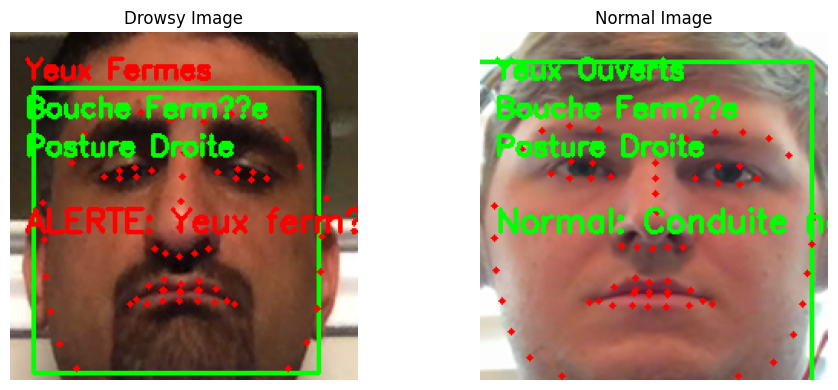


=== Analyse Image Somnolence ===
Statut: FATIGUE
Message: ALERTE: Yeux fermés détectés. Fatigue grave conduite pas du tout requise.
ear_droit: 0.1773
ear_gauche: 0.1734
ear_moyen: 0.1753
mar: 0.1624
angle_tete: 0.7572

=== Analyse Image Normale ===
Statut: NORMAL
Message: Normal: Conduite normale requise.
ear_droit: 0.2701
ear_gauche: 0.2875
ear_moyen: 0.2788
mar: 0.2004
angle_tete: 1.5939


In [ ]:
# Définir vos dossiers contenant les images
dossier_drowsy = "/content/drive/MyDrive/kaggle/drowsiness_ddd_data/drowsiness_dataset_extract/Drowsy"
dossier_non_drowsy = "/content/drive/MyDrive/kaggle/drowsiness_ddd_data/drowsiness_dataset_extract/Non Drowsy"

def demonstration_aleatoire():
    detecteur_visage, predicteur_points = charger_detecteurs()
    indices_visage = definir_indices_points()

    # Sélection aléatoire d'images
    image_drowsy_path = os.path.join(dossier_drowsy, random.choice(os.listdir(dossier_drowsy)))
    image_normal_path = os.path.join(dossier_non_drowsy, random.choice(os.listdir(dossier_non_drowsy)))

    image_drowsy = cv2.imread(image_drowsy_path)
    image_normal = cv2.imread(image_normal_path)

    analyse_drowsy = analyser_image(image_drowsy, detecteur_visage, predicteur_points, indices_visage)
    analyse_normal = analyser_image(image_normal, detecteur_visage, predicteur_points, indices_visage)

    image_drowsy_viz = visualiser_analyse(image_drowsy, analyse_drowsy["resultats_detection"], analyse_drowsy)
    image_normal_viz = visualiser_analyse(image_normal, analyse_normal["resultats_detection"], analyse_normal)

    # Afficher les images
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.imshow(cv2.cvtColor(image_drowsy_viz, cv2.COLOR_BGR2RGB))
    plt.title("Drowsy Image")
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(cv2.cvtColor(image_normal_viz, cv2.COLOR_BGR2RGB))
    plt.title("Normal Image")
    plt.axis('off')

    plt.tight_layout()
    plt.show()

    # Afficher les caractéristiques et les statuts dans la console
    print("\n=== Analyse Image Somnolence ===")
    print(f"Statut: {analyse_drowsy['statut']}")
    print(f"Message: {analyse_drowsy['message']}")
    if analyse_drowsy["caracteristiques"]:
        for cle, valeur in analyse_drowsy["caracteristiques"].items():
            print(f"{cle}: {valeur:.4f}")

    print("\n=== Analyse Image Normale ===")
    print(f"Statut: {analyse_normal['statut']}")
    print(f"Message: {analyse_normal['message']}")
    if analyse_normal["caracteristiques"]:
        for cle, valeur in analyse_normal["caracteristiques"].items():
            print(f"{cle}: {valeur:.4f}")

# Lancer la démo aléatoire
demonstration_aleatoire()


## **MODELISATION**

**Importations des bibliothèque et paramètres globaux**

In [ ]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50, EfficientNetB0
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.metrics import Recall, Precision, AUC
from sklearn.metrics import confusion_matrix, f1_score, roc_curve, auc, precision_recall_curve
import matplotlib.pyplot as plt
import cv2
import time
import pandas as pd
image_size = (160, 160)
batch_size= 32
epochs = 20


**Chargement et préparation des données**

In [ ]:
train_dir = "/content/drive/MyDrive/kaggle/drowsiness_dataset_split/train"
test_dir = "/content/drive/MyDrive/kaggle/drowsiness_dataset_split/test"
val_dir = "/content/drive/MyDrive/kaggle/drowsiness_dataset_split/val"

# Définition des générateurs de données
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='binary'
)

validation_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='binary'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False
)

Found 33434 images belonging to 2 classes.
Found 6268 images belonging to 2 classes.
Found 2091 images belonging to 2 classes.


In [ ]:
# from tensorflow.keras.applications import ResNet50

# base_model = ResNet50(
#     weights='imagenet',
#     include_top=False,
#     input_shape=(image_size[0], image_size[1], 3),
# )

In [ ]:
# base_model.summary()

Model: "resnet50"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_6       │ (None, 160, 160,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 166, 166,  │          0 │ input_layer_6[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 80, 80,    │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 80, 80,    │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 80, 80,    │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 82, 82,    │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 40, 40,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 40, 40,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 40, 40,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 40, 40,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 40, 40,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 40, 40,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 40, 40,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 40, 40,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 40, 40,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 40, 40,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 40, 40,    │      1,024 │ conv2_block1_3_c

 Total params: 23,587,712 (89.98 MB)

 Trainable params: 23,534,592 (89.78 MB)

 Non-trainable params: 53,120 (207.50 KB)

In [ ]:
# model=keras.Sequential() #empty

# for layer in base_model.layers[:-25] :
#     layer.trainable = False

In [ ]:
# x = base_model.output
# x = Flatten()(x)
# x = Dense(1024, activation='relu')(x)
# x = Dense(512, activation='relu')(x)
# predictions = Dense(2, activation='softmax')(x)

In [ ]:
# model = Model(inputs=base_model.input, outputs=predictions)
# model.summary()

Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_6       │ (None, 160, 160,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 166, 166,  │          0 │ input_layer_6[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 80, 80,    │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 80, 80,    │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 80, 80,    │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 82, 82,    │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 40, 40,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 40, 40,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 40, 40,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 40, 40,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 40, 40,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 40, 40,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 40, 40,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 40, 40,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 40, 40,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 40, 40,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 40, 40,    │      1,024 │ conv2_block1_3_c

 Total params: 76,543,362 (291.99 MB)

 Trainable params: 62,945,794 (240.12 MB)

 Non-trainable params: 13,597,568 (51.87 MB)

In [ ]:
# model.compile(optimizer=Adam(0.0001 ), loss='sparse_categorical_crossentropy', metrics=['accuracy', Recall(), Precision(), AUC()])

In [ ]:
# from tensorflow.keras.preprocessing.image import ImageDataGenerator

# # Définir l'ImageDataGenerator pour les données d'entraînement et de validation
# train_datagen = ImageDataGenerator(
#     rescale=1./255,  # Normalisation des pixels pour les mettre dans l'intervalle [0, 1]
#     horizontal_flip=True,
#     rotation_range=40,
#     shear_range=0.2,
#     zoom_range=0.2,
#     fill_mode='nearest'
# )

# val_datagen = ImageDataGenerator(rescale=1./255)

# # Définir les répertoires pour les données d'entraînement et de validation
# train_dir = "/content/drive/MyDrive/kaggle/drowsiness_dataset_split/train"
# test_dir = "/content/drive/MyDrive/kaggle/drowsiness_dataset_split/test"
# val_dir = "/content/drive/MyDrive/kaggle/drowsiness_dataset_split/val"

# # Créer les générateurs de données pour l'entraînement et la validation
# train_batches = train_datagen.flow_from_directory(
#     train_dir,
#     target_size=(image_size[0], image_size[1]),
#     batch_size=32,
#     class_mode='binary'  # Supposons une classification binaire (Drowsy vs Non-Drowsy)
# )

# val_batches = val_datagen.flow_from_directory(
#     val_dir,
#     target_size=(image_size[0], image_size[1]),
#     batch_size=32,
#     class_mode='binary'
# )

# # Maintenant, vous pouvez entraîner le modèle
# history = model.fit(
#     train_batches,
#     epochs=20,
#     validation_data=val_batches,
#     batch_size=32
# )


Found 33434 images belonging to 2 classes.
Found 6268 images belonging to 2 classes.
Epoch 1/20


InvalidArgumentError: Graph execution error:

Detected at node LogicalAnd defined at (most recent call last):
<stack traces unavailable>
Incompatible shapes: [1,32] vs. [1,64]
	 [[{{node LogicalAnd}}]]
	tf2xla conversion failed while converting __inference_one_step_on_data_39452[]. Run with TF_DUMP_GRAPH_PREFIX=/path/to/dump/dir and --vmodule=xla_compiler=2 to obtain a dump of the compiled functions.
	 [[StatefulPartitionedCall]] [Op:__inference_multi_step_on_iterator_40280]

In [ ]:
!pip install --upgrade tensorflow


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 644.9/644.9 MB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.7/4.7 MB 119.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 123.8 MB/s eta 0:00:00
  Attempting uninstall: ml-dtypes
    Found existing installation: ml-dtypes 0.4.1
    Uninstalling ml-dtypes-0.4.1:
      Successfully uninstalled ml-dtypes-0.4.1
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.18.0
    Uninstalling tensorboard-2.18.0:
      Successfully uninstalled tensorboard-2.18.0
  Attempting uninstall: tensorflow
    Found existing installation: tensorflow 2.18.0
    Uninstalling tensorflow-2.18.0:
      Successfully uninstalled tensorflow-2.18.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-decision-forests 1.11.0 requires tensorflow==2.18.0, but you have te

In [ ]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.metrics import Recall, Precision, AUC
from sklearn.metrics import confusion_matrix, f1_score, roc_curve, auc, precision_recall_curve
import matplotlib.pyplot as plt
import cv2
import time
import pandas as pd
import tensorflow as tf
print(tf.__version__)


# Paramètres
image_size = (160, 160)
batch_size = 32

2.19.0


In [ ]:
!nvidia-smi


Sun May 18 06:01:30 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA A100-SXM4-40GB          Off |   00000000:00:04.0 Off |                    0 |
| N/A   36C    P0             54W /  400W |       0MiB /  40960MiB |      0%      Default |
|                                         |                        |             Disabled |
+-----------------------------------------+-----

In [ ]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))


Num GPUs Available:  1


In [ ]:
# import os
# import numpy as np
# import tensorflow as tf
# from tensorflow.keras.preprocessing.image import ImageDataGenerator
# from tensorflow.keras.applications import ResNet50
# from tensorflow.keras.models import Model
# from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, Flatten
# from tensorflow.keras.optimizers import Adam
# from tensorflow.keras.callbacks import EarlyStopping
# from tensorflow.keras.metrics import Recall, Precision, AUC
# from sklearn.metrics import confusion_matrix, f1_score, roc_curve, auc, precision_recall_curve
# import matplotlib.pyplot as plt
# import cv2
# import time
# import pandas as pd
# import tensorflow as tf
# print(tf.__version__)


# # Paramètres
# image_size = (160, 160)
# batch_size = 32

# # Dossiers des images
# train_dir = "/content/drive/MyDrive/kaggle/drowsiness_dataset_split/train"
# test_dir = "/content/drive/MyDrive/kaggle/drowsiness_dataset_split/test"
# val_dir = "/content/drive/MyDrive/kaggle/drowsiness_dataset_split/val"

# # Définition des générateurs de données
# train_datagen = ImageDataGenerator(rescale=1./255)
# test_datagen = ImageDataGenerator(rescale=1./255)
# val_datagen = ImageDataGenerator(rescale=1./255)

# train_generator = train_datagen.flow_from_directory(
#     train_dir,
#     target_size=image_size,
#     batch_size=batch_size,
#     class_mode='binary'
# )

# validation_generator = val_datagen.flow_from_directory(
#     val_dir,
#     target_size=image_size,
#     batch_size=batch_size,
#     class_mode='binary'
# )

# test_generator = test_datagen.flow_from_directory(
#     test_dir,
#     target_size=image_size,
#     batch_size=batch_size,
#     class_mode='binary',
#     shuffle=False
# )

# # Chargement du modèle de base ResNet50
# base_model = ResNet50(
#     weights='imagenet',
#     include_top=False,
#     input_shape=(image_size[0], image_size[1], 3),
# )

# # Afficher le résumé du modèle de base
# base_model.summary()

# # Création du modèle
# model = tf.keras.Sequential()

# # Gel des premières couches
# for layer in base_model.layers[:-25]:
#     layer.trainable = False

# # Ajouter des couches supplémentaires
# x = base_model.output
# x = Flatten()(x)
# x = Dense(1024, activation='relu')(x)
# x = Dense(512, activation='relu')(x)
# predictions = Dense(1, activation='sigmoid')(x)  # Utilisation de sigmoid pour une sortie binaire

# # Création du modèle final
# model = Model(inputs=base_model.input, outputs=predictions)

# # Afficher le résumé du modèle final
# model.summary()

# # Compilation du modèle
# model.compile(optimizer=Adam(0.0001), loss='binary_crossentropy', metrics=['accuracy', Recall(), Precision(), AUC()])

# # Entraînement du modèle
# history = model.fit(
#     train_generator,  # Corrected here
#     epochs=20,
#     validation_data=validation_generator,  # Corrected here
#     batch_size=batch_size
# )


2.19.0
Found 33434 images belonging to 2 classes.
Found 6268 images belonging to 2 classes.
Found 2091 images belonging to 2 classes.


Model: "resnet50"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 160, 160,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 166, 166,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 80, 80,    │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 80, 80,    │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 80, 80,    │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 82, 82,    │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 40, 40,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 40, 40,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 40, 40,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 40, 40,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 40, 40,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 40, 40,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 40, 40,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 40, 40,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 40, 40,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 40, 40,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 40, 40,    │      1,024 │ conv2_block1_3_c

 Total params: 23,587,712 (89.98 MB)

 Trainable params: 23,534,592 (89.78 MB)

 Non-trainable params: 53,120 (207.50 KB)

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 160, 160,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 166, 166,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 80, 80,    │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 80, 80,    │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 80, 80,    │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 82, 82,    │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 40, 40,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 40, 40,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 40, 40,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 40, 40,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 40, 40,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 40, 40,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 40, 40,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 40, 40,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 40, 40,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 40, 40,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 40, 40,    │      1,024 │ conv2_block1_3_c

 Total params: 76,542,849 (291.99 MB)

 Trainable params: 62,945,281 (240.12 MB)

 Non-trainable params: 13,597,568 (51.87 MB)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
 831/1045 ━━━━━━━━━━━━━━━━━━━━ 15:01 4s/step - accuracy: 0.9247 - auc: 0.9639 - loss: 0.2172 - precision: 0.9253 - recall: 0.9095

KeyboardInterrupt: 

In [ ]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.metrics import Recall, Precision, AUC
from sklearn.metrics import confusion_matrix, f1_score, roc_curve, auc, precision_recall_curve
import matplotlib.pyplot as plt
import cv2
import time
import pandas as pd
import tensorflow as tf
print(tf.__version__)
from tensorflow.keras.applications import ResNet50, EfficientNetB0

# Paramètres
image_size = (160, 160)
batch_size = 32
epochs = 20
fine_tune_epochs = 5

2.19.0


**Construction des modèles ResNet50 et EfficientNetB0**

In [ ]:
# # Modèle ResNet50
# def build_resnet_model():
#     base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(160, 160, 3))

#     # Geler seulement les 5 premières couches (moins de gel pour plus de paramètres entraînables)
#     for layer in base_model.layers[:-1]:  # Gel des 5 premières couches seulement
#         layer.trainable = False

#     # Ajouter des couches supplémentaires
#     x = base_model.output
#     x = GlobalAveragePooling2D()(x)
#     x = Dense(1024, activation='relu')(x)
#     x = Dropout(0.5)(x)
#     predictions = Dense(1, activation='sigmoid')(x)

#     return Model(inputs=base_model.input, outputs=predictions)

# Modèle MobileNetV2
from tensorflow.keras.applications import MobileNetV2
def build_mobilenet_model():
    base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(160, 160, 3))

    # Geler les premières couches (réduire la complexité)
    for layer in base_model.layers[:-25]:  # Gel des premières couches
        layer.trainable = False

    # Ajouter des couches supplémentaires
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(1024, activation='relu')(x)
    x = Dropout(0.5)(x)
    predictions = Dense(1, activation='sigmoid')(x)

    return Model(inputs=base_model.input, outputs=predictions)


# # Modèle EfficientNetB0
# def build_efficientnet_model():
#     base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(160, 160, 3))

#     # Geler seulement les 5 premières couches
#     for layer in base_model.layers[:-25]:  # Gel des 5 premières couches seulement
#         layer.trainable = False

#     # Ajouter des couches supplémentaires
#     x = base_model.output
#     x = GlobalAveragePooling2D()(x)
#     x = Dense(1024, activation='relu')(x)
#     x = Dropout(0.5)(x)
#     predictions = Dense(1, activation='sigmoid')(x)


# Modèle EfficientNetB0 avec ajustements
def build_efficientnet_model():
    base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(160, 160, 3))

    # Geler les premières couches pour réduire la complexité
    for layer in base_model.layers[:-25]:  # Gel des 25 premières couches
        layer.trainable = False

    # Ajouter des couches supplémentaires
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(1024, activation='relu')(x)
    x = Dropout(0.6)(x)  # Augmenter le dropout pour éviter l'overfitting
    predictions = Dense(1, activation='sigmoid')(x)

    return Model(inputs=base_model.input, outputs=predictions)


**Compilation, entraînement, fine-tuning et évaluation**

In [ ]:
# Compilation et entraînement

def compile_and_train_model(model, train_generator, validation_generator):
    model.compile(
        optimizer=Adam(learning_rate=0.0001),
        loss='binary_crossentropy',
        metrics=['accuracy', Recall(), Precision(), AUC()]
    )
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    history = model.fit(
        train_generator,
        epochs=epochs,
        validation_data=validation_generator,
        callbacks=[early_stopping]
    )
    return model, history

**Fine-tuning des modèles avec epochs dédiés**

In [ ]:
def fine_tune_model(model, train_generator, validation_generator, fine_tune_epochs=5):
    for layer in model.layers[-25:]:
        layer.trainable = False

    model.compile(
        optimizer=Adam(learning_rate=0.0001),
        loss='binary_crossentropy',
        metrics=['accuracy', Recall(), Precision(), AUC()]
    )

    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

    history = model.fit(
        train_generator,
        epochs=fine_tune_epochs,
        validation_data=validation_generator,
        callbacks=[early_stopping]
    )

    return model, history

**résumé des modèles**

In [ ]:
# Création des modèles
# resnet_model = build_resnet_model()
mobilenet_model = build_mobilenet_model()
efficientnet_model = build_efficientnet_model()

print("Résumé du modèle MObilenetV2 :")
mobilenet_model.summary()

# print("\n Résumé du modèle ResNet50 :")
# resnet_model.summary()

print("\n Résumé du modèle EfficientNetB0 :")
efficientnet_model.summary()

Résumé du modèle MObilenetV2 :


Model: "functional_17"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_19      │ (None, 160, 160,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 80, 80,    │        864 │ input_layer_19[0… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 80, 80,    │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 80, 80,    │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 80, 80,    │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 80, 80,    │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 80, 80,    │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 80, 80,    │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 80, 80,    │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 80, 80,    │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 80, 80,    │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 80, 80,    │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 81, 81,    │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 40, 40,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 40, 40,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 40, 40,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 40, 40,    │      2,304 │ block_1_depthwis

 Total params: 3,570,753 (13.62 MB)

 Trainable params: 2,674,689 (10.20 MB)

 Non-trainable params: 896,064 (3.42 MB)


 Résumé du modèle EfficientNetB0 :


Model: "functional_18"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_20      │ (None, 160, 160,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_14        │ (None, 160, 160,  │          0 │ input_layer_20[0… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization_7     │ (None, 160, 160,  │          7 │ rescaling_14[0][… │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_15        │ (None, 160, 160,  │          0 │ normalization_7[… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv_pad       │ (None, 161, 161,  │          0 │ rescaling_15[0][… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 80, 80,    │        864 │ stem_conv_pad[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 80, 80,    │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 80, 80,    │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, 80, 80,    │        288 │ stem_activation[… │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, 80, 80,    │        128 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, 80, 80,    │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 32)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 32)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 8)   │        264 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 32)  │        288 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, 80, 80,    │          0 │ block1a_activati… │
│ (Multiply)          │ 32)               │            │ block1a_se_expan… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 80, 80,    │        512 │ block1a_se_excit

 Total params: 5,362,340 (20.46 MB)

 Trainable params: 2,775,521 (10.59 MB)

 Non-trainable params: 2,586,819 (9.87 MB)

**Entraînement avec mesure du temps**

In [ ]:
# Entraînement MobileNetV2
print("Training MobileNetV2 model...")
start_time_mobilenet = time.time()

# Compilation et entraînement du modèle MobileNetV2
mobilenet_model, history_mobilenet = compile_and_train_model(mobilenet_model, train_generator, validation_generator)

end_time_mobilenet = time.time()

# Temps d'entraînement
print(f"Training time for MobileNetV2: {end_time_mobilenet - start_time_mobilenet} seconds")

Training MobileNetV2 model...
Epoch 1/20
1045/1045 ━━━━━━━━━━━━━━━━━━━━ 206s 183ms/step - accuracy: 0.9706 - auc_5: 0.9905 - loss: 0.0715 - precision_5: 0.9697 - recall_5: 0.9682 - val_accuracy: 0.9769 - val_auc_5: 0.9953 - val_loss: 0.0890 - val_precision_5: 0.9541 - val_recall_5: 0.9983
Epoch 2/20
1045/1045 ━━━━━━━━━━━━━━━━━━━━ 179s 171ms/step - accuracy: 0.9989 - auc_5: 1.0000 - loss: 0.0044 - precision_5: 0.9984 - recall_5: 0.9992 - val_accuracy: 0.9998 - val_auc_5: 0.9998 - val_loss: 0.0022 - val_precision_5: 1.0000 - val_recall_5: 0.9997
Epoch 3/20
1045/1045 ━━━━━━━━━━━━━━━━━━━━ 177s 169ms/step - accuracy: 0.9994 - auc_5: 1.0000 - loss: 0.0017 - precision_5: 0.9993 - recall_5: 0.9994 - val_accuracy: 0.9992 - val_auc_5: 1.0000 - val_loss: 0.0010 - val_precision_5: 0.9983 - val_recall_5: 1.0000
Epoch 4/20
1045/1045 ━━━━━━━━━━━━━━━━━━━━ 178s 171ms/step - accuracy: 0.9995 - auc_5: 0.9999 - loss: 0.0016 - precision_5: 0.9994 - recall_5: 0.9995 - val_accuracy: 0.9992 - val_auc_5: 0.999

In [ ]:
# # Entraînement ResNet
# print("Training ResNet model...")
# start_time_resnet = time.time()
# resnet_model, history_resnet = compile_and_train_model(resnet_model, train_generator, validation_generator)
# end_time_resnet = time.time()

Training ResNet model...
Epoch 1/20


FailedPreconditionError: Graph execution error:

Detected at node StatefulPartitionedCall defined at (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main

  File "<frozen runpy>", line 88, in _run_code

  File "/usr/local/lib/python3.11/dist-packages/colab_kernel_launcher.py", line 37, in <module>

  File "/usr/local/lib/python3.11/dist-packages/traitlets/config/application.py", line 992, in launch_instance

  File "/usr/local/lib/python3.11/dist-packages/ipykernel/kernelapp.py", line 712, in start

  File "/usr/local/lib/python3.11/dist-packages/tornado/platform/asyncio.py", line 205, in start

  File "/usr/lib/python3.11/asyncio/base_events.py", line 608, in run_forever

  File "/usr/lib/python3.11/asyncio/base_events.py", line 1936, in _run_once

  File "/usr/lib/python3.11/asyncio/events.py", line 84, in _run

  File "/usr/local/lib/python3.11/dist-packages/ipykernel/kernelbase.py", line 510, in dispatch_queue

  File "/usr/local/lib/python3.11/dist-packages/ipykernel/kernelbase.py", line 499, in process_one

  File "/usr/local/lib/python3.11/dist-packages/ipykernel/kernelbase.py", line 406, in dispatch_shell

  File "/usr/local/lib/python3.11/dist-packages/ipykernel/kernelbase.py", line 730, in execute_request

  File "/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py", line 383, in do_execute

  File "/usr/local/lib/python3.11/dist-packages/ipykernel/zmqshell.py", line 528, in run_cell

  File "/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py", line 2975, in run_cell

  File "/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py", line 3030, in _run_cell

  File "/usr/local/lib/python3.11/dist-packages/IPython/core/async_helpers.py", line 78, in _pseudo_sync_runner

  File "/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py", line 3257, in run_cell_async

  File "/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py", line 3473, in run_ast_nodes

  File "/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code

  File "<ipython-input-49-9cceb675035d>", line 4, in <cell line: 0>

  File "<ipython-input-47-10a0ff2627b9>", line 10, in compile_and_train_model

  File "/usr/local/lib/python3.11/dist-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/usr/local/lib/python3.11/dist-packages/keras/src/backend/tensorflow/trainer.py", line 371, in fit

  File "/usr/local/lib/python3.11/dist-packages/keras/src/backend/tensorflow/trainer.py", line 219, in function

  File "/usr/local/lib/python3.11/dist-packages/keras/src/backend/tensorflow/trainer.py", line 132, in multi_step_on_iterator

DNN library initialization failed. Look at the errors above for more details.
	 [[{{node StatefulPartitionedCall}}]] [Op:__inference_multi_step_on_iterator_73210]

In [ ]:
# Entraînement EfficientNet
print("Training EfficientNet model...")
start_time_effnet = time.time()
efficientnet_model, history_effnet = compile_and_train_model(efficientnet_model, train_generator, validation_generator)
end_time_effnet = time.time()

# Temps d'entraînement
print(f"Training time for EfficientNet: {end_time_mobilenet - start_time_mobilenet} seconds")

Training EfficientNet model...
Epoch 1/20
1045/1045 ━━━━━━━━━━━━━━━━━━━━ 228s 193ms/step - accuracy: 0.6958 - auc_7: 0.7597 - loss: 0.5661 - precision_7: 0.7176 - recall_7: 0.5663 - val_accuracy: 0.6543 - val_auc_7: 0.8267 - val_loss: 0.5781 - val_precision_7: 0.5810 - val_recall_7: 0.9215
Epoch 2/20
1045/1045 ━━━━━━━━━━━━━━━━━━━━ 178s 170ms/step - accuracy: 0.7224 - auc_7: 0.7954 - loss: 0.5348 - precision_7: 0.7450 - recall_7: 0.6135 - val_accuracy: 0.7873 - val_auc_7: 0.8683 - val_loss: 0.4528 - val_precision_7: 0.8551 - val_recall_7: 0.6536
Epoch 3/20
1045/1045 ━━━━━━━━━━━━━━━━━━━━ 178s 170ms/step - accuracy: 0.7477 - auc_7: 0.8303 - loss: 0.4955 - precision_7: 0.7805 - recall_7: 0.6298 - val_accuracy: 0.7766 - val_auc_7: 0.8722 - val_loss: 0.4688 - val_precision_7: 0.8764 - val_recall_7: 0.6053
Epoch 4/20
1045/1045 ━━━━━━━━━━━━━━━━━━━━ 178s 170ms/step - accuracy: 0.7808 - auc_7: 0.8604 - loss: 0.4542 - precision_7: 0.8146 - recall_7: 0.6818 - val_accuracy: 0.4944 - val_auc_7: 0.72

**Fine-tuning et historique dédié**

In [ ]:
print("Fine-tuning ResNet model...")
# resnet_model, history_resnet_ft = fine_tune_model(resnet_model, train_generator, validation_generator, fine_tune_epochs=fine_tune_epochs)

mobilenet_model, history_mobilenet_ft = fine_tune_mobilenet_model(mobilenet_model, train_generator, validation_generator, fine_tune_epochs)

print("Fine-tuning EfficientNet model...")
efficientnet_model, history_effnet_ft = fine_tune_model(efficientnet_model, train_generator, validation_generator, fine_tune_epochs=fine_tune_epochs)

Fine-tuning ResNet model...
Epoch 1/5
1045/1045 ━━━━━━━━━━━━━━━━━━━━ 220s 190ms/step - accuracy: 0.9449 - auc_8: 0.9834 - loss: 0.1275 - precision_8: 0.9445 - recall_8: 0.9362 - val_accuracy: 0.9531 - val_auc_8: 0.9967 - val_loss: 0.1161 - val_precision_8: 0.9970 - val_recall_8: 0.9019
Epoch 2/5
1045/1045 ━━━━━━━━━━━━━━━━━━━━ 175s 168ms/step - accuracy: 0.9925 - auc_8: 0.9994 - loss: 0.0232 - precision_8: 0.9919 - recall_8: 0.9921 - val_accuracy: 0.9982 - val_auc_8: 0.9997 - val_loss: 0.0064 - val_precision_8: 0.9983 - val_recall_8: 0.9979
Epoch 3/5
 130/1045 ━━━━━━━━━━━━━━━━━━━━ 2:09 141ms/step - accuracy: 0.9954 - auc_8: 0.9997 - loss: 0.0144 - precision_8: 0.9963 - recall_8: 0.9941

KeyboardInterrupt: 

**Tracé des courbes d'entraînement initial et fine-tuning**

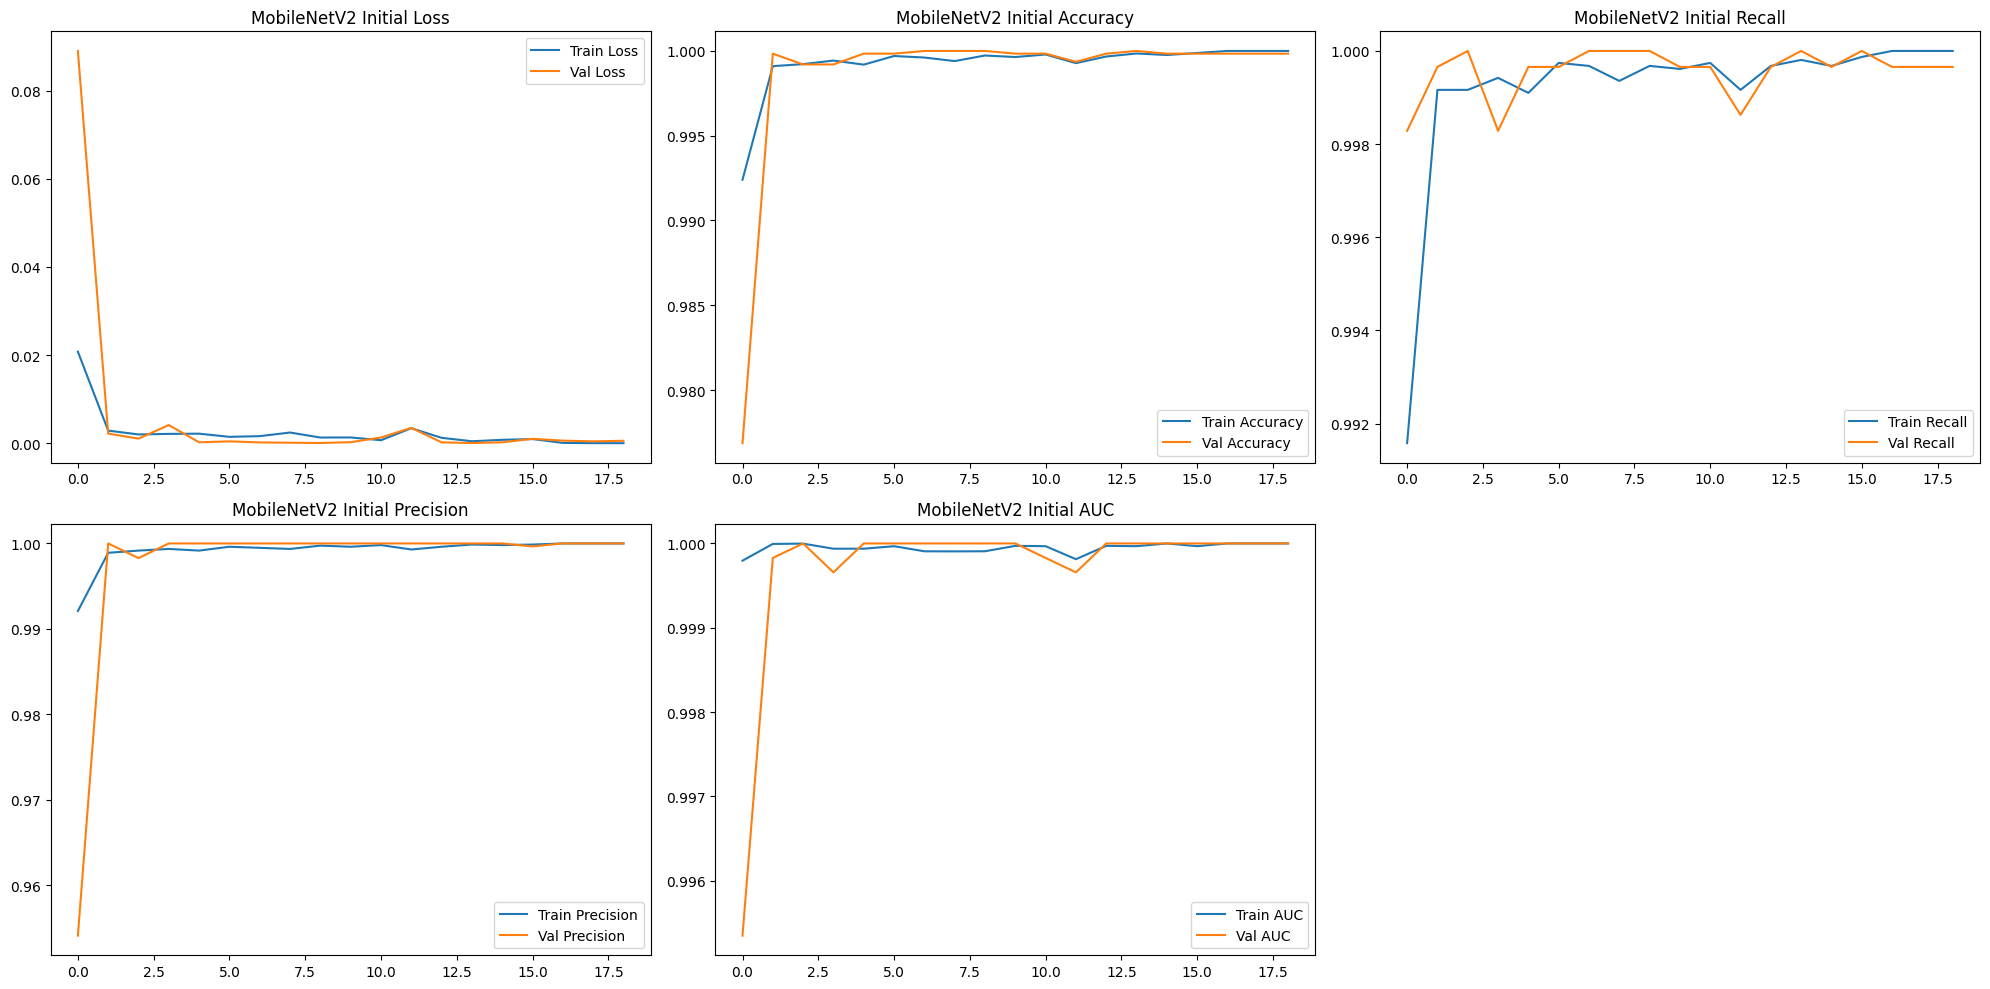

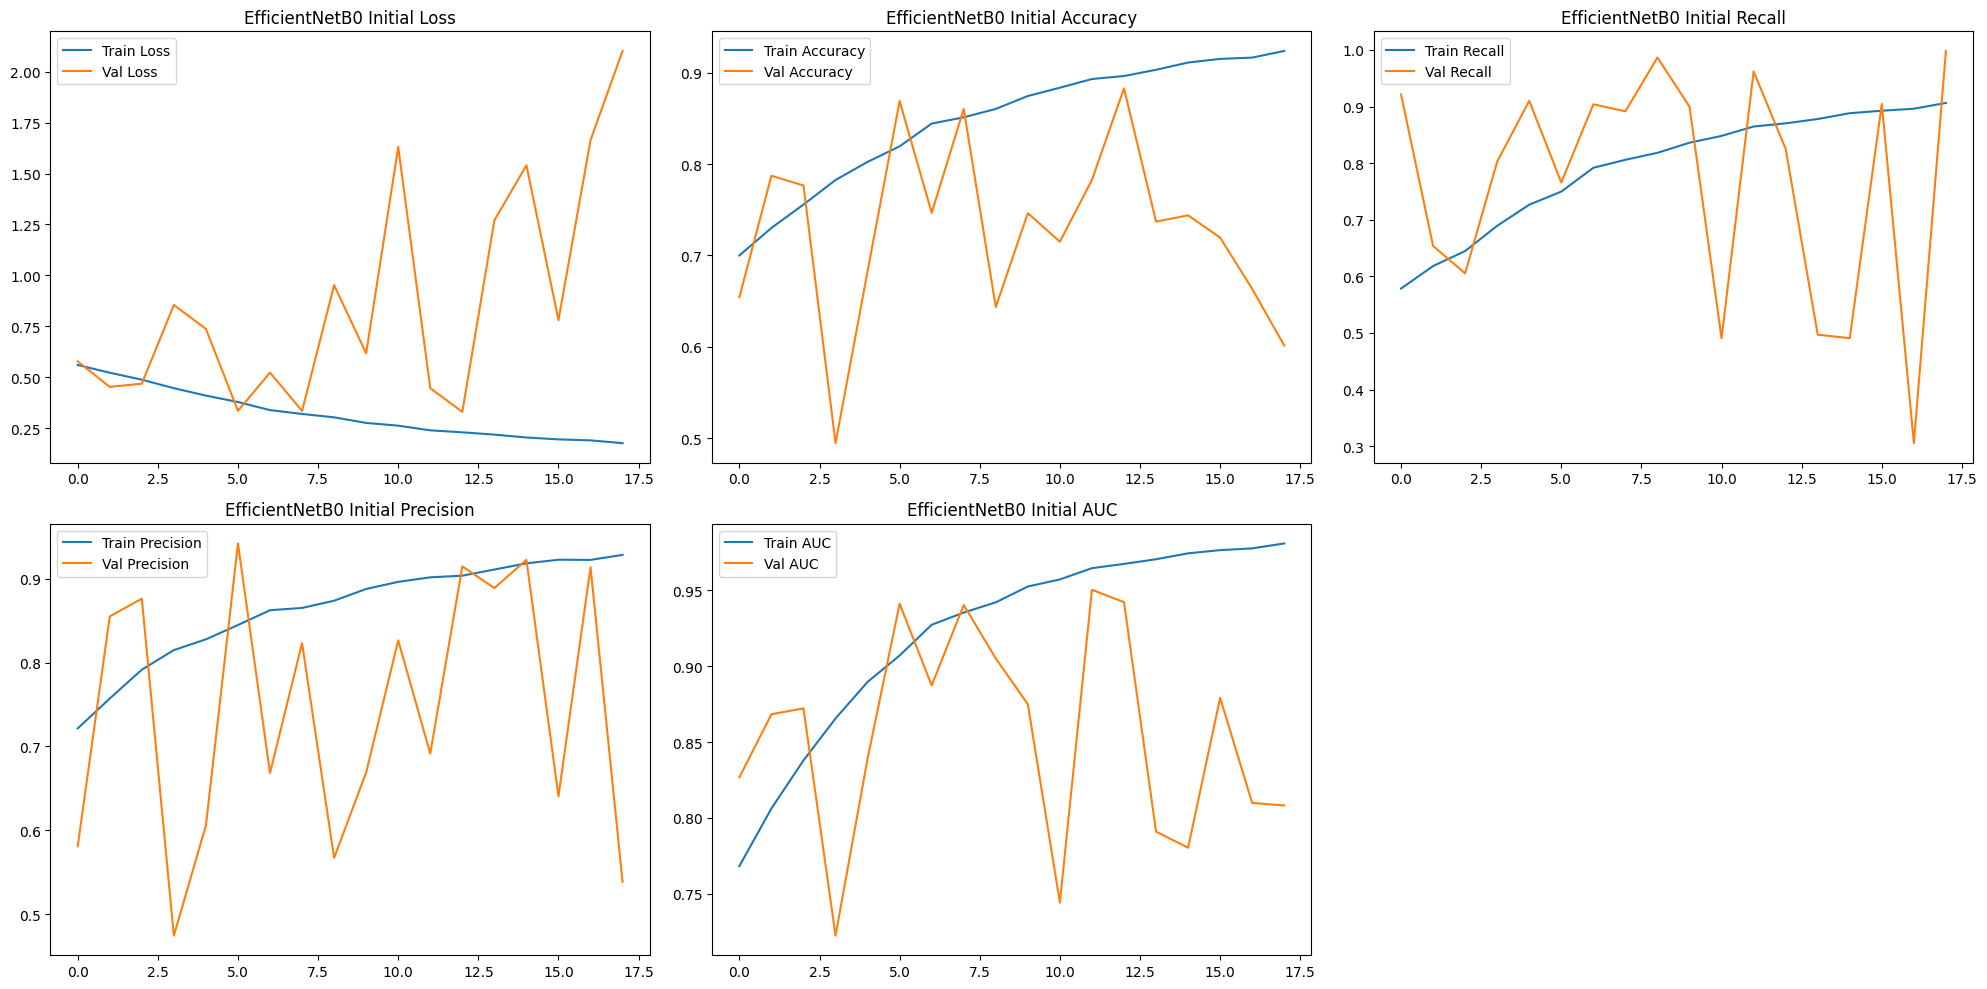

In [ ]:
def plot_training_history(history, title='Model'):
    plt.figure(figsize=(20, 10))

    # Perte
    plt.subplot(2, 3, 1)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title(f'{title} Loss')
    plt.legend()

    # Accuracy
    plt.subplot(2, 3, 2)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Val Accuracy')
    plt.title(f'{title} Accuracy')
    plt.legend()

    # Recall
    plt.subplot(2, 3, 3)
    recall_key = next((k for k in history.history.keys() if 'recall' in k and not k.startswith('val_')), None)
    val_recall_key = next((k for k in history.history.keys() if 'recall' in k and k.startswith('val_')), None)
    if recall_key and val_recall_key:
        plt.plot(history.history[recall_key], label='Train Recall')
        plt.plot(history.history[val_recall_key], label='Val Recall')
        plt.title(f'{title} Recall')
        plt.legend()

    # Precision
    plt.subplot(2, 3, 4)
    precision_key = next((k for k in history.history.keys() if 'precision' in k and not k.startswith('val_')), None)
    val_precision_key = next((k for k in history.history.keys() if 'precision' in k and k.startswith('val_')), None)
    if precision_key and val_precision_key:
        plt.plot(history.history[precision_key], label='Train Precision')
        plt.plot(history.history[val_precision_key], label='Val Precision')
        plt.title(f'{title} Precision')
        plt.legend()

    # AUC
    plt.subplot(2, 3, 5)
    auc_key = next((k for k in history.history.keys() if 'auc' in k and not k.startswith('val_')), None)
    val_auc_key = next((k for k in history.history.keys() if 'auc' in k and k.startswith('val_')), None)
    if auc_key and val_auc_key:
        plt.plot(history.history[auc_key], label='Train AUC')
        plt.plot(history.history[val_auc_key], label='Val AUC')
        plt.title(f'{title} AUC')
        plt.legend()

    plt.tight_layout()
    plt.show()

# Entraînement initial
plot_training_history(history_mobilenet, 'MobileNetV2 Initial')
plot_training_history(history_effnet, 'EfficientNetB0 Initial')

# Fine-tuning
# plot_training_history(history_resnet_ft, 'ResNet50 Fine-Tuning')
# plot_training_history(history_effnet_ft, 'EfficientNetB0 Fine-Tuning')

**Évaluation, Confusion Matrix, F1-score, Résumé tableau**

In [ ]:
# # Évaluation
# print("Evaluating ResNet model...")
# resnet_metrics = resnet_model.evaluate(test_generator)

# print("Evaluating EfficientNet model...")
# efficientnet_metrics = efficientnet_model.evaluate(test_generator)

# # Analyse avancée
# print("Analyzing ResNet model...")

# resnet_preds = resnet_model.predict(test_generator) >= 0.5
# efficientnet_preds = efficientnet_model.predict(test_generator) >= 0.5

# true_labels = test_generator.classes

# resnet_cm = confusion_matrix(true_labels, resnet_preds)
# efficientnet_cm = confusion_matrix(true_labels, efficientnet_preds)

# resnet_f1 = f1_score(true_labels, resnet_preds)
# efficientnet_f1 = f1_score(true_labels, efficientnet_preds)

# resnet_time = end_time_resnet - start_time_resnet
# efficientnet_time = end_time_effnet - start_time_effnet

# # Résumé tableau
# results_df = pd.DataFrame({
#     'Model': ['ResNet50', 'EfficientNetB0'],
#     'Accuracy': [resnet_metrics[1], efficientnet_metrics[1]],
#     'Recall': [resnet_metrics[2], efficientnet_metrics[2]],
#     'Precision': [resnet_metrics[3], efficientnet_metrics[3]],
#     'AUC': [resnet_metrics[4], efficientnet_metrics[4]],
#     'F1 Score': [resnet_f1, efficientnet_f1],
#     'Training Time (min)': [resnet_time / 60, efficientnet_time / 60]
# })

# print(results_df)
# print("ResNet Confusion Matrix:\n", resnet_cm)
# print("EfficientNet Confusion Matrix:\n", efficientnet_cm)

Evaluating ResNet model...
4/4 ━━━━━━━━━━━━━━━━━━━━ 67s 17s/step - accuracy: 0.7067 - auc_5: 0.4129 - loss: 0.6476 - precision_5: 0.0000e+00 - recall_5: 0.0000e+00
Evaluating EfficientNet model...
4/4 ━━━━━━━━━━━━━━━━━━━━ 20s 4s/step - accuracy: 0.7067 - auc_6: 0.4000 - loss: 0.6685 - precision_6: 0.0000e+00 - recall_6: 0.0000e+00
4/4 ━━━━━━━━━━━━━━━━━━━━ 49s 11s/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 26s 5s/step
            Model  Accuracy  Recall  Precision       AUC  F1 Score  \
0        ResNet50  0.534442     0.0        0.0  0.468776       0.0   
1  EfficientNetB0  0.534442     0.0        0.0  0.500000       0.0   

   Training Time (min)  
0           139.634017  
1            62.739570  
ResNet Confusion Matrix:
 [[225   0]
 [196   0]]
EfficientNet Confusion Matrix:
 [[225   0]
 [196   0]]


In [ ]:
import pandas as pd
from sklearn.metrics import confusion_matrix, f1_score

# Évaluation du modèle MobileNetV2
print("Evaluating MobileNetV2 model...")
mobilenet_metrics = mobilenet_model.evaluate(test_generator)

# Évaluation du modèle EfficientNet
print("Evaluating EfficientNet model...")
efficientnet_metrics = efficientnet_model.evaluate(test_generator)

# Analyse avancée
print("Analyzing MobileNetV2 model...")

# Prédictions avec seuil de 0.5
mobilenet_preds = mobilenet_model.predict(test_generator) >= 0.5
efficientnet_preds = efficientnet_model.predict(test_generator) >= 0.5

# Labels réels
true_labels = test_generator.classes

# Calcul de la confusion matrix
mobilenet_cm = confusion_matrix(true_labels, mobilenet_preds)
efficientnet_cm = confusion_matrix(true_labels, efficientnet_preds)

# Calcul du F1 score
mobilenet_f1 = f1_score(true_labels, mobilenet_preds)
efficientnet_f1 = f1_score(true_labels, efficientnet_preds)

# Temps d'entraînement pour chaque modèle
mobilenet_time = end_time_mobilenet - start_time_mobilenet
efficientnet_time = end_time_effnet - start_time_effnet

# Résumé sous forme de tableau
results_df = pd.DataFrame({
    'Model': ['MobileNetV2', 'EfficientNetB0'],
    'Accuracy': [mobilenet_metrics[1], efficientnet_metrics[1]],
    'Recall': [mobilenet_metrics[2], efficientnet_metrics[2]],
    'Precision': [mobilenet_metrics[3], efficientnet_metrics[3]],
    'AUC': [mobilenet_metrics[4], efficientnet_metrics[4]],
    'F1 Score': [mobilenet_f1, efficientnet_f1],
    'Training Time (min)': [mobilenet_time / 60, efficientnet_time / 60]
})

# Affichage du tableau des résultats
print(results_df)

# Affichage des matrices de confusion
print("MobileNetV2 Confusion Matrix:\n", mobilenet_cm)
print("EfficientNet Confusion Matrix:\n", efficientnet_cm)


Evaluating MobileNetV2 model...


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


66/66 ━━━━━━━━━━━━━━━━━━━━ 515s 8s/step - accuracy: 1.0000 - auc_5: 0.4925 - loss: 1.3017e-05 - precision_5: 0.4925 - recall_5: 0.4925
Evaluating EfficientNet model...
66/66 ━━━━━━━━━━━━━━━━━━━━ 18s 275ms/step - accuracy: 0.9243 - auc_7: 0.4700 - loss: 0.2126 - precision_7: 0.3952 - recall_7: 0.4119
Analyzing MobileNetV2 model...
66/66 ━━━━━━━━━━━━━━━━━━━━ 16s 188ms/step
66/66 ━━━━━━━━━━━━━━━━━━━━ 21s 230ms/step
            Model  Accuracy    Recall  Precision       AUC  F1 Score  \
0     MobileNetV2  1.000000  1.000000   1.000000  1.000000  1.000000   
1  EfficientNetB0  0.890005  0.824255   0.931475  0.946809  0.874591   

   Training Time (min)  
0            56.627681  
1            54.183627  
MobileNetV2 Confusion Matrix:
 [[1118    0]
 [   0  973]]
EfficientNet Confusion Matrix:
 [[1059   59]
 [ 171  802]]


**La matrice de confusion **

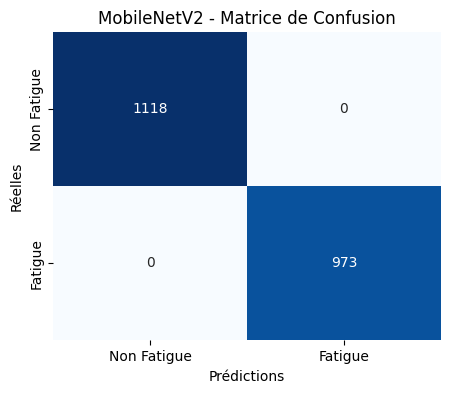

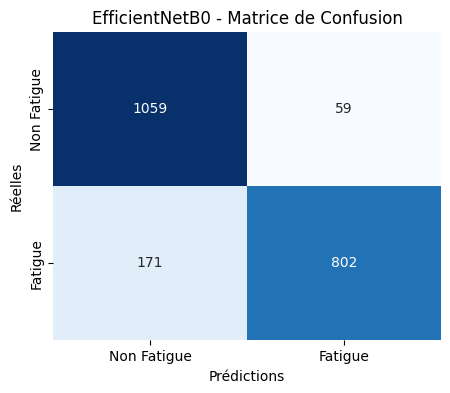

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

def plot_confusion_matrix(cm, model_name='Model'):
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=['Non Fatigue', 'Fatigue'],
                yticklabels=['Non Fatigue', 'Fatigue'])
    plt.title(f'{model_name} - Matrice de Confusion')
    plt.xlabel('Prédictions')
    plt.ylabel('Réelles')
    plt.show()

# 🔥 Affichage pour MobileNetV2
plot_confusion_matrix(mobilenet_cm, 'MobileNetV2')

# 🔥 Affichage pour EfficientNet
plot_confusion_matrix(efficientnet_cm, 'EfficientNetB0')

**Prise de décision (détection sur image unique)**

In [ ]:
def preprocess_image(image, target_size=image_size):
    image = cv2.resize(image, target_size)
    image = image / 255.0
    image = np.expand_dims(image, axis=0)
    return image

def detect_fatigue(model, image, threshold=0.5):   #seuil = thresold
    preprocessed_image = preprocess_image(image)
    prediction = model.predict(preprocessed_image)[0][0]
    if prediction >= threshold:
        print(f"⚠️ Probabilité de fatigue détectée: {prediction:.2f},Vous présentez des signes de fatigue, veuillez vous garer et vous reposer. ")
    else:
        print(f"✅ Probabilité de vigilance détectée: {prediction:.2f}, Vous êtes en bonne condition pour conduire.")

**Détection automatique sur images test (visuel)**

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


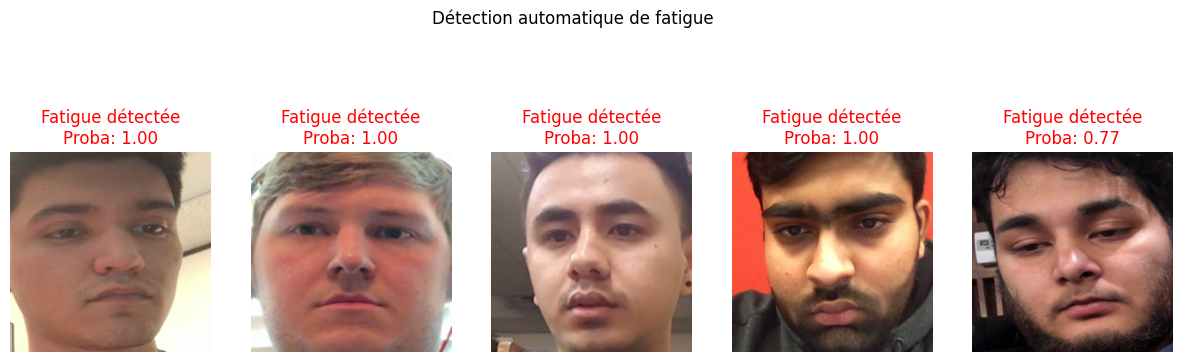

In [ ]:
import random

def show_fatigue_detection_on_images(model, test_dir, threshold=0.5, num_images=5):
    categories = os.listdir(test_dir)
    images_paths = []
    for category in categories:
        category_path = os.path.join(test_dir, category)
        if os.path.isdir(category_path):
            images = os.listdir(category_path)
            for img in images:
                images_paths.append(os.path.join(category_path, img))

    sample_images = random.sample(images_paths, num_images)

    plt.figure(figsize=(15, 5))
    for i, img_path in enumerate(sample_images):
        img = cv2.imread(img_path)
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        preprocessed_img = preprocess_image(img)
        prediction = model.predict(preprocessed_img)[0][0]
        label = "Fatigue détectée" if prediction >= threshold else "Pas de fatigue"
        color = 'red' if prediction >= threshold else 'green'
        plt.subplot(1, num_images, i+1)
        plt.imshow(img_rgb)
        plt.title(f"{label}\nProba: {prediction:.2f}", color=color)
        plt.axis('off')
    plt.suptitle("Détection automatique de fatigue")
    plt.show()

show_fatigue_detection_on_images(resnet_model, test_dir)

**Courbe ROC et Precision-Recall**

66/66 ━━━━━━━━━━━━━━━━━━━━ 9s 140ms/step


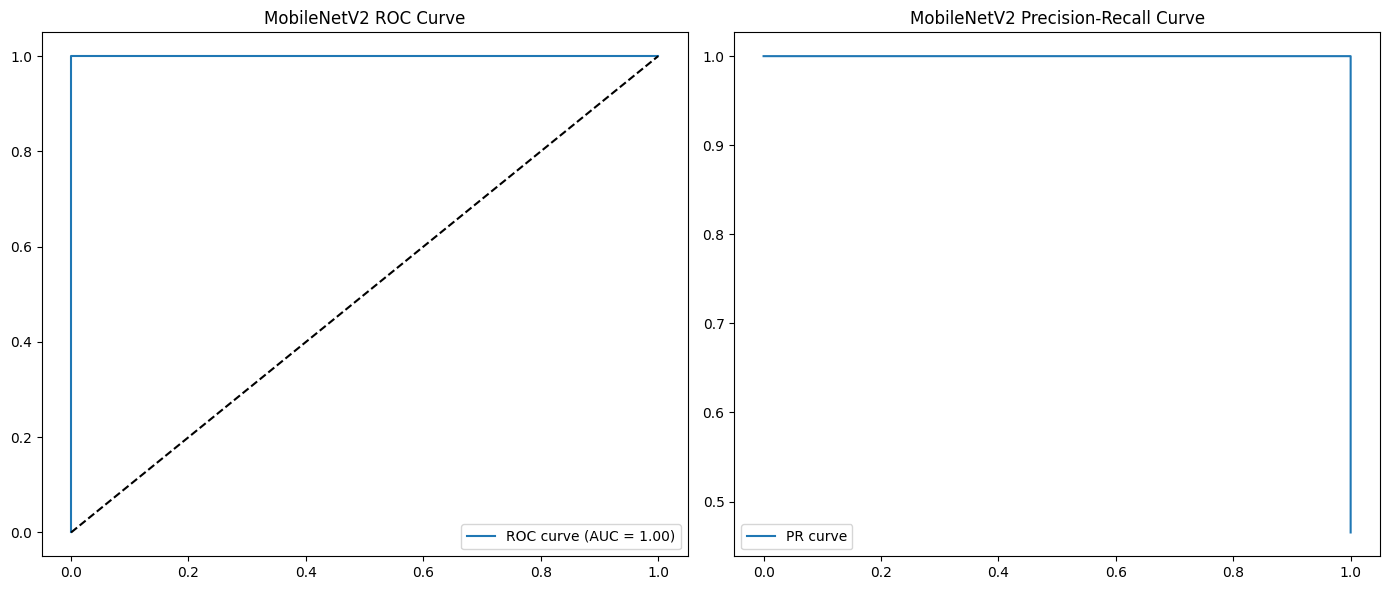

66/66 ━━━━━━━━━━━━━━━━━━━━ 9s 139ms/step


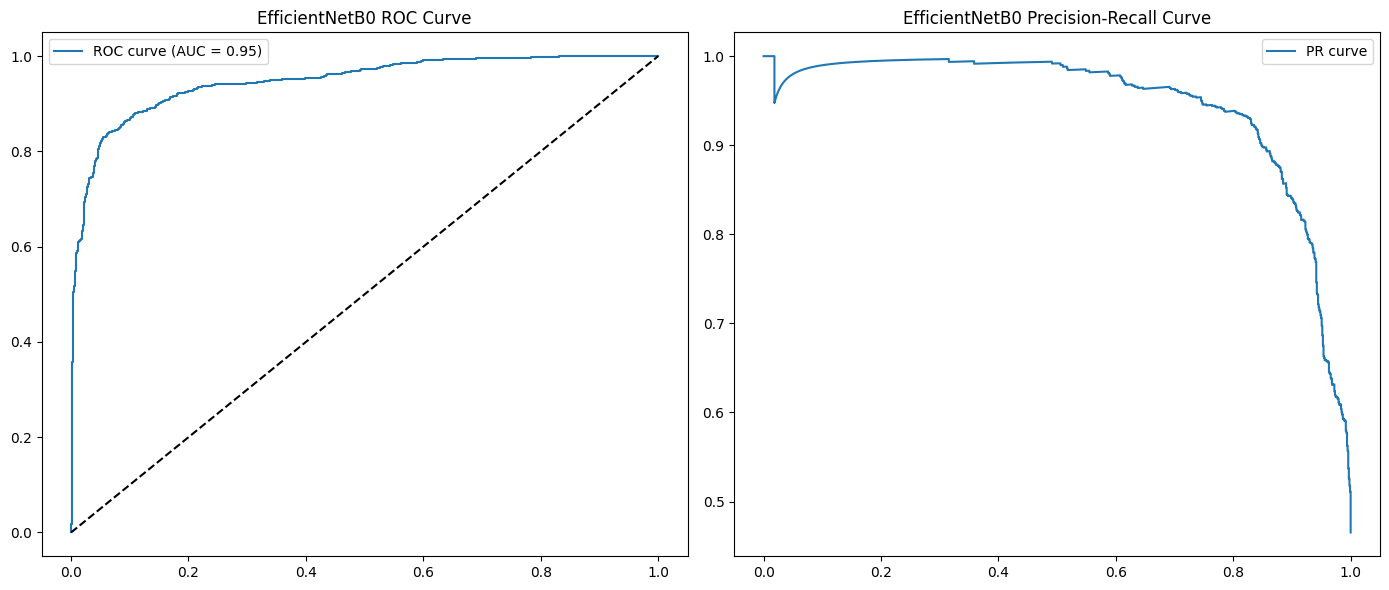

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, precision_recall_curve

def plot_roc_pr_curves(model, test_generator, model_name='Model'):
    pred_probs = model.predict(test_generator).ravel()  # Prédictions des probabilités
    true_labels = test_generator.classes  # Étiquettes réelles

    # Courbe ROC
    fpr, tpr, _ = roc_curve(true_labels, pred_probs)
    roc_auc = auc(fpr, tpr)

    # Courbe Precision-Recall
    precision, recall, _ = precision_recall_curve(true_labels, pred_probs)

    # Affichage des courbes
    plt.figure(figsize=(14, 6))

    # Courbe ROC
    plt.subplot(1, 2, 1)
    plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.title(f'{model_name} ROC Curve')
    plt.legend()

    # Courbe Precision-Recall
    plt.subplot(1, 2, 2)
    plt.plot(recall, precision, label='PR curve')
    plt.title(f'{model_name} Precision-Recall Curve')
    plt.legend()

    plt.tight_layout()
    plt.show()

# 🔥 Affichage pour MobileNetV2
plot_roc_pr_curves(mobilenet_model, test_generator, 'MobileNetV2')

# 🔥 Affichage pour EfficientNetB0
plot_roc_pr_curves(efficientnet_model, test_generator, 'EfficientNetB0')


**Rapport synthèse automatique**

In [ ]:
def generate_report(results_df):
    for index, row in results_df.iterrows():
        model = row['Model']
        acc = row['Accuracy']
        recall = row['Recall']
        precision = row['Precision']
        auc_score = row['AUC']
        f1 = row['F1 Score']
        time_min = row['Training Time (min)']

        print(f"🔹 Modèle : {model}")
        print(f"- Accuracy : {acc:.4f}")
        print(f"- Recall : {recall:.4f}")
        print(f"- Precision : {precision:.4f}")
        print(f"- F1-Score : {f1:.4f}")
        print(f"- AUC : {auc_score:.4f}")
        print(f"- Temps d'entraînement : {time_min:.2f} minutes")

        # Recommandation selon le contexte sécurité
        if recall < 0.85:
            print(f"⚠️ Attention : Le Recall est faible (<0.85). Cela peut entraîner des cas de fatigue non détectée (faux négatifs). Il est conseillé d'améliorer la sensibilité du modèle ou d'abaisser le seuil.")
        else:
            print(f"✅ Bon niveau de Recall, le modèle est capable de détecter correctement les cas de fatigue.")

        if precision < 0.80:
            print(f"⚠️ Attention : Le modèle a un Precision inférieur à 0.80. Risque de fausse alerte pouvant gêner l'utilisateur.")

        print("-" * 60)

# 🔥 Utilisation
generate_report(results_df)


🔹 Modèle : MobileNetV2
- Accuracy : 1.0000
- Recall : 1.0000
- Precision : 1.0000
- F1-Score : 1.0000
- AUC : 1.0000
- Temps d'entraînement : 56.63 minutes
✅ Bon niveau de Recall, le modèle est capable de détecter correctement les cas de fatigue.
------------------------------------------------------------
🔹 Modèle : EfficientNetB0
- Accuracy : 0.8900
- Recall : 0.8243
- Precision : 0.9315
- F1-Score : 0.8746
- AUC : 0.9468
- Temps d'entraînement : 54.18 minutes
⚠️ Attention : Le Recall est faible (<0.85). Cela peut entraîner des cas de fatigue non détectée (faux négatifs). Il est conseillé d'améliorer la sensibilité du modèle ou d'abaisser le seuil.
------------------------------------------------------------
